# Assignment 3 Group 85
Authors: *Niclas Lindmark, Noa Sjöstrand, Anton Johansson*

Course: *DAT405 Introduction to data science and AI*

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import seaborn as sns

from sklearn.cluster import DBSCAN
from sklearn import metrics
from sklearn import datasets
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import silhouette_score

In [39]:
# reading data

d = pd.read_csv('./data_assignment3.csv')

xValues = d['phi']
yValues = d['psi']

d_PRO = pd.DataFrame(d.loc[d['residue name'] == 'PRO'])
d

,residue name,position,chain,phi,psi
0,LYS,10,A,-149.312855,142.657714
1,PRO,11,A,-44.283210,136.002076
2,LYS,12,A,-119.972621,-168.705263
3,LEU,13,A,-135.317212,137.143523
4,LEU,14,A,-104.851467,95.928520
...,...,...,...,...,...
29364,GLY,374,B,-147.749557,155.223562
29365,GLN,375,B,-117.428541,133.019506
29366,ILE,376,B,-113.586448,112.091970
29367,ASN,377,B,-100.668779,-12.102821


##  1. Visualizing distribution
**Show the distribution of phi and psi combinations using a scatter plot and 2D histogram**

### Scatter plot

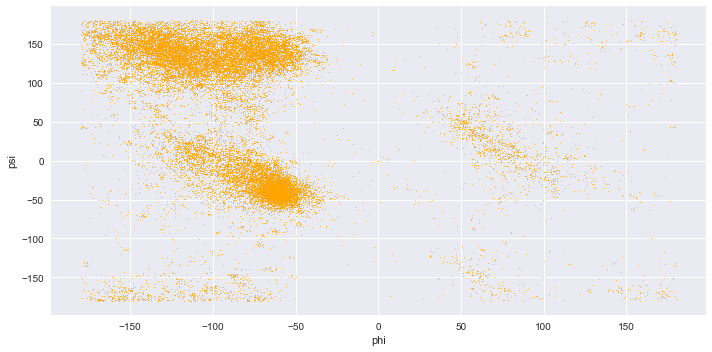

In [89]:
plt.style.use('seaborn')
plt.rcParams["figure.figsize"] = [10, 5]
plt.rcParams["figure.autolayout"] = True

plt.scatter(xValues,yValues,s=0.5, alpha=0.8, c='orange')
plt.xlabel('phi')
plt.ylabel('psi')

plt.show()

### 2D histogram

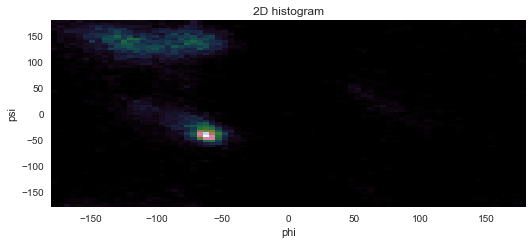

In [73]:
plt.hist2d(xValues, yValues, 75, cmap="cubehelix")
plt.xlabel('phi')
plt.ylabel('psi')
plt.title('2D histogram')
plt.show()

## 2. KMeans
**Use the K-means clustering method to cluster the phi and psi angle combinations in 
the data file.**



best fit is: (3, 0.6724895253169637)


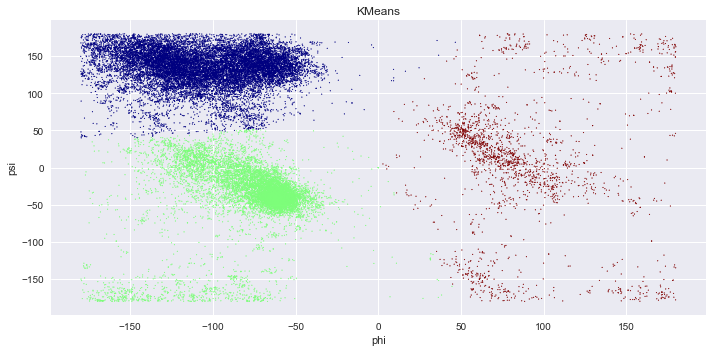

In [88]:
xy_vals = list(zip(xValues, yValues))
X = np.array(xy_vals)

score = -1
best_fit = (0, 0, 0)
for n_clusters in range(2, 5):
    kmeans = KMeans(n_clusters, n_init=10).fit_predict(X)
    new_score = silhouette_score(X, kmeans)
    if new_score > score:
        score = new_score
        best_fit = (n_clusters, score)
        d['color_kmeans'] = kmeans
 
plt.scatter(d['phi'], d['psi'], c=d['color_kmeans'], s=0.7,cmap='jet')
plt.xlabel('phi')
plt.ylabel('psi')
plt.title('KMeans')

print(f'best fit is: {best_fit}')
plt.show()

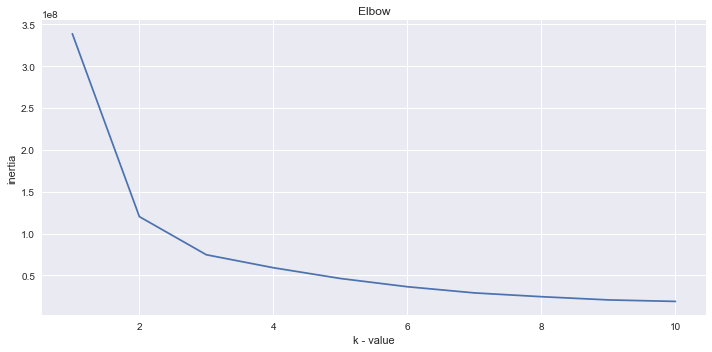

In [77]:
wcss = []

for i in range(1, 11):
    clustering = KMeans(n_clusters=i, init='k-means++', random_state=42, n_init=10)
    clustering.fit(X)
    wcss.append(clustering.inertia_)
    
ks = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
sns.lineplot(x = ks, y = wcss)
plt.title('Elbow')
plt.xlabel('k - value')
plt.ylabel('inertia')

plt.show()

### Answer 2:
a) We chose k=3 based on the elbow diagram and silouette score. First we used the elbow diagram to approximate the k value, then we used the siluette score to iterate through values close to our approcomation to fint the k value with the highest score. 

b) Our clusters seems fairly resonable since they have sperated the most obvious clusters. However as it is a k-means clustering all the noice have also been assignet to a cluster. That is not ideal. Also the angles at the bottom and top of the scatter plot are accually next to each other, but our k-means clustering have not managed to take this into account. 

## 3. DBSCAN

**Using the DBSCAN method to cluster the phi and psi angle combinations in the data file.**


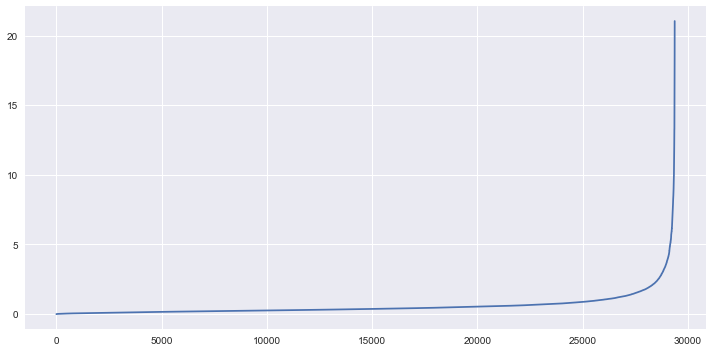

In [96]:
neigh = NearestNeighbors(n_neighbors=2)
nbrs = neigh.fit(X)
distances, indices = nbrs.kneighbors(X)
distances = np.sort(distances, axis=0)
distances = distances[:,1]
plt.plot(distances)

best epsilon: 15
best min samples: 200
0.6084435508126602
Number of clusters: 3


Text(0, 0.5, 'psi')

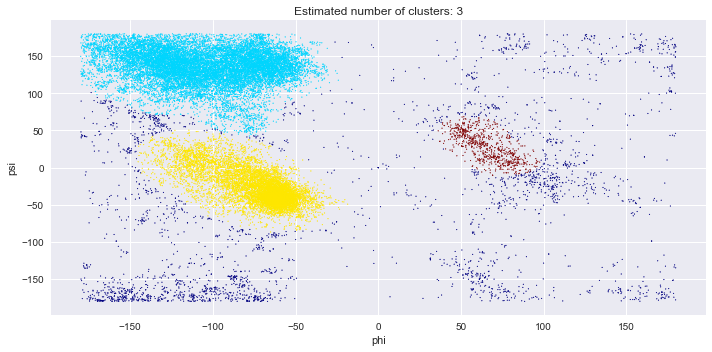

In [86]:
# computing the best DBSCAN

best_e = 0 
best_l = 0
best_sc = 0
best_ms = 0

for e in range(1, 50, 1):
    for ms in range(10, 300, 10):
        labels = DBSCAN(eps=e, min_samples=ms).fit_predict(X)
        if len(set(labels)) > 1:
            sc = silhouette_score(X, labels)
            if  sc > best_sc:
                best_sc = sc
                best_e = e
                best_l = labels
                best_ms = ms
            
d['color_dbscan'] = best_l
print(f'best epsilon: {best_e}')
print(f'best min samples: {best_ms}')
print(best_sc)
print(f'Number of clusters: {len(set(best_l))-1}')

plt.scatter(d['phi'], d['psi'], c=d['color_dbscan'], s=0.7,cmap='jet')
plt.title(f'Estimated number of clusters: {len(set(best_l))-1}') 
plt.xlabel('phi')
plt.ylabel('psi')


### Assesing clusters and outliers

In [90]:
# counting the number of clusters
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1) 

print('Estimated number of clusters: %d' % n_clusters_) 
print('Estimated number of noise points: %d' % n_noise_) 


Estimated number of clusters: 3
Estimated number of noise points: 2698


### Outliers

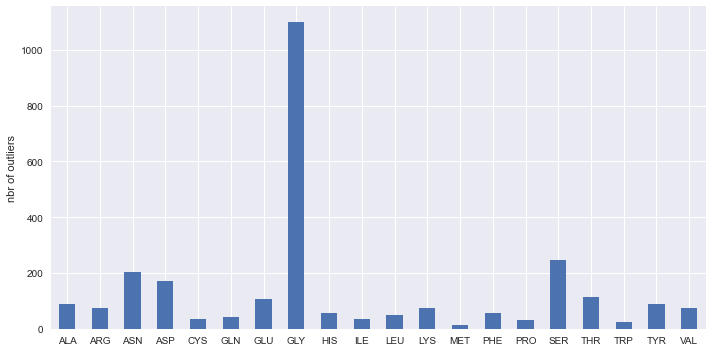

In [92]:
d_outliers = pd.DataFrame(d.loc[d['color_dbscan'] == -1])
d_outliers['residue name'].value_counts().sort_index().plot(kind='bar', rot=0, ylabel='nbr of outliers', )
plt.show()

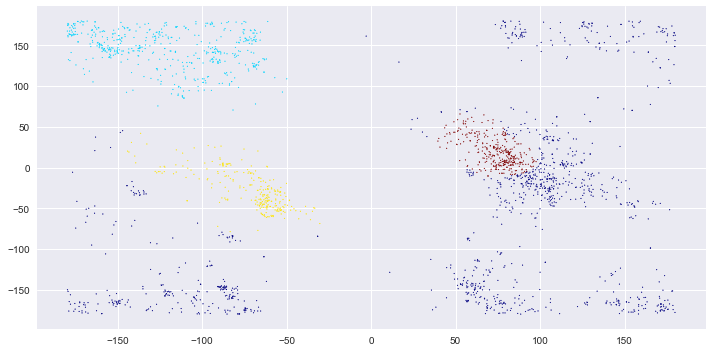

In [93]:
d_GLY = pd.DataFrame(d.loc[d['residue name'] == 'GLY'])
plt.scatter(d_GLY['phi'], d_GLY['psi'], c=d_GLY['color_dbscan'], s=0.7,cmap='jet')

### Answer 3:

a) We chose eps and minimum num of sample points based on the silouette score. First we used nearest_neighbors which gave 3 as the optimal eps. But after trying eps=3 at different min_samples, no matter the value on minimum num of samples the silhouette score was poor (under 0.3).

We iterated through diffrent values for epsilon and min num samples to understand what was resonable. We did not want more than 5 clusters, not too much noise and a high siluette score. We iterated throught diffrent values for eps and min samples and found that eps sould be 15 and min sample should be 200. That combination achieved a silouette score of 0.608, which is acceptable, whilst keeping the number of clusters at 3.

b) You can see the clusters in our plots.

c) You can see this in the graphs above.

## 4. DBSCAN with only residue type PRO
**The data file can be stratified by amino acid residue type. Use DBSCAN to cluster the 
data that have residue type PRO.**

### Plot data

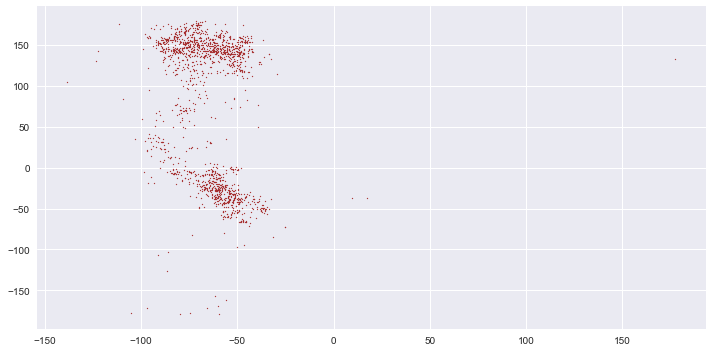

In [99]:
d_PRO = pd.DataFrame(d.loc[d['residue name'] == 'PRO'])
plt.scatter(d_PRO['phi'], d_PRO['psi'], s=1, c='brown')

### DBSCAN on PRO data

best epsilon: 50
best min samples: 250
0.7782783299593291
Estimated number of clusters: 2
Estimated number of noise points: 11
3


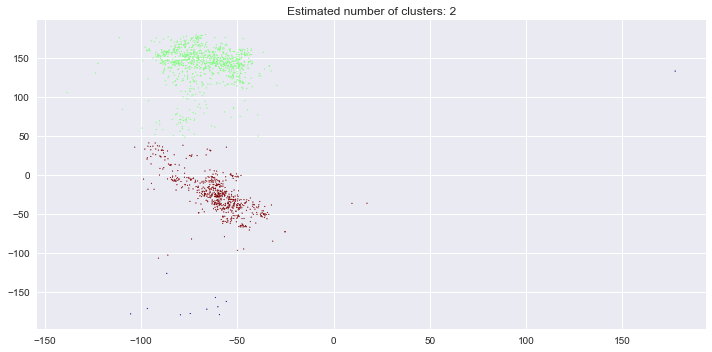

In [100]:


xy_PROvals = list(zip(d_PRO['phi'], d_PRO['psi']))
XPRO = np.array(xy_PROvals)

# computing the DBSCAN

best_e = 0 
best_l = 0
best_sc = 0
best_ms = 0
for e in range(30, 55, 1):
    for ms in range(50, 500, 10):
        labels = DBSCAN(eps=e, min_samples=ms).fit_predict(XPRO)
        if len(set(labels)) > 1:
            sc = silhouette_score(XPRO, labels)
            if  sc > best_sc:
                best_sc = sc
                best_e = e
                best_l = labels
                best_ms = ms
                
d_PRO['color_dbscan'] = best_l
print(f'best epsilon: {best_e}')
print(f'best min samples: {best_ms}')
print(best_sc)
d_PRO['color_dbscan'] = best_l
n_clusters_ = len(set(best_l)) - (1 if -1 in best_l else 0)
n_noise_ = list(best_l).count(-1)
print('Estimated number of clusters: %d' % n_clusters_) 
print('Estimated number of noise points: %d' % n_noise_)

plt.scatter(d_PRO['phi'], d_PRO['psi'], c=d_PRO['color_dbscan'], s=0.7,cmap='jet')
plt.title('Estimated number of clusters: %d' % n_clusters_) 
print(len(set(best_l)))

### Answer 4: 

Compared to the general clusters the PRO variants are more easily "clusterable", meaning there is less noise. We have two distinct areas of clusters with high density of this variant. Noise points went from over 2500 to 11. Even though the sample size is smaller in the only-PRO data this is still a conciderable difference between outliers in relation to the number of samples.

This also resulted in completley different optimal values for epsilon and min num of samples. Both values were bigger. Also, a better silhouette score indicates the clustering is more accurate. 